# 1. Import Libraries and Set Directory
---

Import Libraries

In [1]:
is_drive = 0

In [2]:
if is_drive==1 :
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# directory management
import os
from glob import glob
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# audio analysis
import librosa 
import librosa.display
import IPython.display as ipd
# imports for colors and plots
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
# imports for NN
import tensorflow as tf
from tensorflow import keras
import time

# 3. Load Dataset and Training the Models
---

## 3.1. Loading Spectograms

In [5]:
# Spectogram Path
if is_drive==1 :   
    TRAIN_DIR = "/content/drive/MyDrive/spectogram-dataset/Train/"
    TEST_DIR = "/content/drive/MyDrive/spectogram-dataset/Test/"
else :
    TRAIN_DIR = "../Project/spectogram-dataset/Train/"
    TEST_DIR = "../Project/spectogram-dataset/Test/"

In [6]:
def load_fsdd(train_spectrograms_path,test_spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(train_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_train.append(spectrogram)
    x_train = np.array(x_train)        # -> (n_samples, n_bins, n_frames)
    x_train = x_train[..., np.newaxis] # -> (1200, 800, 32, 1)

    x_test  = []
    for root, _, file_names in os.walk(test_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_test.append(spectrogram)
    x_test = np.array(x_test)        # -> (n_samples, n_bins, n_frames)
    x_test = x_test[..., np.newaxis] # -> (300, 800, 32, 1)

    return x_train,x_test

In [19]:
x_train, x_test = load_fsdd(TRAIN_DIR, TEST_DIR)

## 3.3 Deep Convolutional AE

In [8]:
from autoencoder import Autoencoder

In [20]:
x_train_ae = x_train # (12800 / 154) + 1 = 84.116
x_test_ae = x_test
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 15
encoding_dim = 16 
print(x_train_ae.shape)
print(x_test_ae.shape)

(1200, 160, 84, 1)
(300, 160, 84, 1)


In [21]:
AE = Autoencoder(
    input_shape=(160, 84, 1),
    conv_filters=(32, 64, 64, 64),
    conv_kernels=(3, 3, 3, 3),
    conv_strides=(1, 2, 2, 1),
    latent_space_dim=encoding_dim
)

In [22]:
AE.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 160, 84, 1)]      0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 160, 84, 32)      320       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 160, 84, 32)       0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 160, 84, 32)      128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 80, 42, 64)       18496     
 D)                                                              
                                                           

In [23]:
AE.compile(LEARNING_RATE)

In [24]:
tic=time.time()
with tf.device('/GPU:1'):
    hist = AE.train(x_train_ae, x_test_ae, BATCH_SIZE, EPOCHS)
toc=time.time()
training_time=toc-tic

Train on 1200 samples, validate on 300 samples
Epoch 1/15
1200/1200 [==============================] - ETA: 0s - loss: 0.0581

c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1200/1200 [==============================] - 119s 99ms/sample - loss: 0.0581 - val_loss: 0.0848
Epoch 2/15
1200/1200 [==============================] - 113s 95ms/sample - loss: 0.0212 - val_loss: 0.0508
Epoch 3/15
1200/1200 [==============================] - 106s 89ms/sample - loss: 0.0155 - val_loss: 0.0506
Epoch 4/15
1200/1200 [==============================] - 101s 84ms/sample - loss: 0.0131 - val_loss: 0.0494
Epoch 5/15
1200/1200 [==============================] - 99s 83ms/sample - loss: 0.0114 - val_loss: 0.0475
Epoch 6/15
1200/1200 [==============================] - 105s 88ms/sample - loss: 0.0107 - val_loss: 0.0391
Epoch 7/15
1200/1200 [==============================] - 112s 93ms/sample - loss: 0.0099 - val_loss: 0.0312
Epoch 8/15
1200/1200 [==============================] - 107s 90ms/sample - loss: 0.0094 - val_loss: 0.0242
Epoch 9/15
1200/1200 [==============================] - 111s 92ms/sample - loss: 0.0089 - val_loss: 0.0195
Epoch 10/15
1200/1200 [==========================

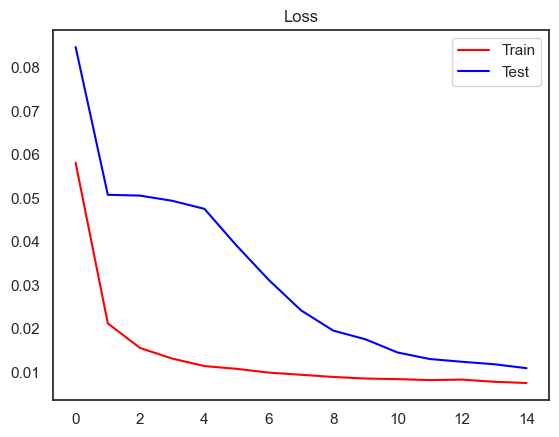

In [25]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.show()

In [26]:
AE.save("AE-model")